In [94]:
# Collect Directory Files

import pandas as pd
import os
import numpy as np
#directory = "./Signal_588000_trunc"
directory = "./Signal_588000_VWAP_duoyinzi"
i = 0
file_dic = {}
#signal = pd.read_pickle("./Signal_588000_trunc/20201202.txt")
for filename in os.listdir(directory):
    file_dic[i] = directory + '/' + filename
    i += 1
from numba import jit
from joblib import Parallel, delayed

# Add Punish Term
# Fen Qu Duan

# Function

In [2]:
#@jit(nopython = True)
def strategy_ret_log(ask_bid, volume, vol_lim, time):
    log = pd.DataFrame()
    cash = 0
    position = 0
    num_trans = 0
    cum_pos_short = 0
    only_short = False
    only_long = False
    pin = False
    # abt 卖出时负， vol always position
    for abt, vol, t in zip(ask_bid, volume,time):
        if pin:
            if abt < 0:
                continue
            elif abt > 0:
                to_add = min(-1*position, vol)
                cash -= 1.0001 * abt * to_add
                position += to_add
                log = log.append({'Time':t, 'Volume': to_add, 'Price': abt,'position': position,'cum_short':cum_pos_short, 's':0}, ignore_index = True)
                if position == 0:
                    break
                else:
                    continue
        # 平仓所需卖出+已卖出等于底仓时， 并且卖出信号 (position always >= 0)
        elif (cum_pos_short + position) >= 6000000:
            if abt >= 0:
                continue
            elif abt < 0:
        # cash 加上 卖出金额，如当前对手盘不到平仓位则只卖对手盘
                to_min = min(6000000 - cum_pos_short, vol)
                cash -= 0.9999 * abt * to_min
                position -= to_min
                cum_pos_short += to_min
                log = log.append({'Time':t, 'Volume': to_min, 'Price': abt,'position': position,'cum_short':cum_pos_short, 's':1}, ignore_index = True)
                # 如果在卖出后已达到底仓，结束当天操作
            if cum_pos_short >= 6000000:
                pin = True   
            continue
        # 平仓所需卖出+已卖出+tick对手盘等于底仓
        if abt == 0:
            continue
        elif abt > 0 and not only_short:
            # 买入信号且总卖出再加上当前对手盘+仓位 超出底仓
            # Cash 减去买入金额，且只买入底仓与当前仓位总卖出差值，如可以，买到满底仓
            if (cum_pos_short + vol + position) >= 6000000:
                to_add = min((6000000 - cum_pos_short - position), vol, vol_lim - position)
                cash -= 1.0001 * to_add * abt
                position += to_add
                log = log.append({'Time':t, 'Volume': to_add, 'Price': abt, 'position': position,'cum_short':cum_pos_short,'s':2}, ignore_index = True)
                if position == vol_lim:
                    only_short = True
                    only_long = False
            # 如果突破过limit of cumulative sell 并且 对手盘足以平仓到零
            elif only_long and vol >= -1 * position:
                # 平到零
                to_min = -1*position
                position = position + to_min
                # 不再突破过limit of cumulative buy
                only_long = False
                cash -= 1.0001 * to_min * abt
                log = log.append({'Time':t, 'Volume': to_min, 'Price': abt,'position': position, 'cum_short':cum_pos_short, 's':3}, ignore_index = True)
                num_trans += 1
            # 下一次交易将突破limit                
            elif (position + vol) >= vol_lim:
                to_add = (vol_lim - position)
                position += to_add
                cash -= 1.0001 * to_add * abt
                log = log.append({'Time':t, 'Volume': to_add, 'Price': abt, 'position': position,'cum_short':cum_pos_short, 's':4}, ignore_index = True)    
                num_trans += 1
                only_short = True
            # normal trading
            else:
                position += vol
                cash -= 1.0001 * vol * abt  # (1+换手率) * 1手 * ask
                log = log.append({'Time':t, 'Volume':vol, 'Price': abt, 'position': position, 'cum_short':cum_pos_short,'s':5}, ignore_index = True)
                num_trans += 1
        elif abt < 0 and not only_long:
            if (cum_pos_short + vol) >= 6000000:
                to_min = min(vol, 6000000 - cum_pos_short)
                if position - to_min <= -1 * vol_lim:
                    to_min = position + vol_lim
                cash -= 0.9999 * abt * to_min
                position -= to_min
                cum_pos_short += to_min
                log = log.append({'Time':t, 'Volume': to_min, 'Price': abt,'position': position,'cum_short':cum_pos_short, 's':-1}, ignore_index = True)
                if position <= -1 * vol_lim:
                    only_long = True
                    only_short = False
                if cum_pos_short >= 6000000:
                    pin = True
            # 如果突破过limit of cumulative buy 并且 对手盘足以平仓到零
            elif only_short and vol >= position:
                to_add = position 
                position = 0
                only_short = False
                cash -= 0.9999 * to_add * abt
                cum_pos_short += position
                log = log.append({'Time':t, 'Volume': to_add, 'Price': abt,'position': position, 'cum_short':cum_pos_short,'s':6}, ignore_index = True)
                num_trans += 1
            elif (position - vol) <= -1*vol_lim:
                to_min = (position + vol_lim)
                position -= to_min
                cash -= 0.9999 * to_min * abt
                cum_pos_short += to_min
                log = log.append({'Time': t, 'Volume': to_min, 'Price': abt,'position': position, 'cum_short':cum_pos_short,'s':7}, ignore_index = True)
                num_trans += 1
                only_long = True
            else:
                position -= vol
                cash -= 0.9999 * vol * abt  #(1-换手率) * 1手 * bid
                cum_pos_short += vol
                log = log.append({'Time':t, 'Volume': vol, 'Price': abt,'position': position,'cum_short':cum_pos_short, 's':8}, ignore_index = True)
                num_trans += 1  
        
    return [log,position, cash, num_trans,cum_pos_short]


In [3]:
@jit(nopython = True)
def strategy_ret(ask_bid, volume, vol_lim):
    cash = 0
    position = 0
    num_trans = 0
    cum_pos_short = 0
    only_short = False
    only_long = False
    pin = False
    # abt 卖出时负， vol always position
    for abt, vol in zip(ask_bid, volume):
        if pin:
            if abt < 0:
                continue
            elif abt > 0:
                to_add = min(-1*position, vol)
                cash -= 1.0001 * abt * to_add
                position += to_add
                if position == 0:
                    break
                else:
                    continue
        # 平仓所需卖出+已卖出等于底仓时， 并且卖出信号 (position always >= 0)
        elif (cum_pos_short + position) >= 6000000:
            if abt >= 0:
                continue
            elif abt < 0:
        # cash 加上 卖出金额，如当前对手盘不到平仓位则只卖对手盘
                to_min = min(6000000 - cum_pos_short, vol)
                cash -= 0.9999 * abt * to_min
                position -= to_min
                cum_pos_short += to_min
                # 如果在卖出后已达到底仓，结束当天操作
            if cum_pos_short >= 6000000:
                pin = True   
            continue
        # 平仓所需卖出+已卖出+tick对手盘等于底仓
        if abt == 0:
            continue
        elif abt > 0 and not only_short:
            # 买入信号且总卖出再加上当前对手盘+仓位 超出底仓
            # Cash 减去买入金额，且只买入底仓与当前仓位总卖出差值，如可以，买到满底仓
            if (cum_pos_short + vol + position) >= 6000000:
                to_add = min((6000000 - cum_pos_short - position), vol, vol_lim - position)
                cash -= 1.0001 * to_add * abt
                position += to_add
                if position == vol_lim:
                    only_short = True
                    only_long = False
            # 如果突破过limit of cumulative sell 并且 对手盘足以平仓到零
            elif only_long and vol >= -1 * position:
                # 平到零
                to_min = -1*position
                position = position + to_min
                # 不再突破过limit of cumulative buy
                only_long = False
                cash -= 1.0001 * to_min * abt
                num_trans += 1
            # 下一次交易将突破limit                
            elif (position + vol) >= vol_lim:
                to_add = (vol_lim - position)
                position += to_add
                cash -= 1.0001 * to_add * abt
                num_trans += 1
                only_short = True
            # normal trading
            else:
                position += vol
                cash -= 1.0001 * vol * abt  # (1+换手率) * 1手 * ask
                num_trans += 1
        elif abt < 0 and not only_long:
            if (cum_pos_short + vol) >= 6000000:
                to_min = min(vol, 6000000 - cum_pos_short)
                if position - to_min <= -1 * vol_lim:
                    to_min = position + vol_lim
                cash -= 0.9999 * abt * to_min
                position -= to_min
                cum_pos_short += to_min
                if position <= -1 * vol_lim:
                    only_long = True
                    only_short = False
                if cum_pos_short >= 6000000:
                    pin = True
            # 如果突破过limit of cumulative buy 并且 对手盘足以平仓到零
            elif only_short and vol >= position:
                to_add = position 
                position = 0
                only_short = False
                cash -= 0.9999 * to_add * abt
                cum_pos_short += to_add
                num_trans += 1
            elif (position - vol) <= -1*vol_lim:
                to_min = (position + vol_lim)
                position -= to_min
                cash -= 0.9999 * to_min * abt
                cum_pos_short += to_min
                num_trans += 1
                only_long = True
            else:
                position -= vol
                cash -= 0.9999 * vol * abt  #(1-换手率) * 1手 * bid
                cum_pos_short += vol
                num_trans += 1  
        
    return [position, cash, num_trans,cum_pos_short]

def shift1(arr, num, fill_value=np.nan):
    arr = np.roll(arr,num)
    if num < 0:
        arr[num:] = fill_value
    elif num > 0:
        arr[:num] = fill_value
    return arr

'''
ask: ask price
bid: bid price
asl_v: ask volume
bid_v: bid volume
'''
@jit(nopython=True)
def threshold(thres_up, thres_low, signal, ask, bid, ask_v, bid_v):
    long = signal > thres_up
    short = signal < thres_low
    pos = np.subtract(np.multiply(long, ask), np.multiply(short, bid))
    vol = np.add(np.multiply(long, ask_v), np.multiply(short, bid_v))
    return pos, vol


In [4]:
@jit(nopython = True)
def strategy_ret_for_test(ask_bid, volume, vol_lim):
    cash = 0
    position = 0
    num_trans = 0
    cum_pos_short = 0
    only_short = False
    only_long = False
    pin = False
    # abt 卖出时负， vol always position
    for abt, vol in zip(ask_bid, volume):
        if pin:
            if abt < 0:
                continue
            elif abt > 0:
                to_add = min(-1*position, vol)
                cash -= 1.0001 * abt * to_add
                position += to_add
                if position == 0:
                    break
                else:
                    continue
        # 平仓所需卖出+已卖出等于底仓时， 并且卖出信号 (position always >= 0)
        elif (cum_pos_short + position) >= np.inf:
            if abt >= 0:
                continue
            elif abt < 0:
        # cash 加上 卖出金额，如当前对手盘不到平仓位则只卖对手盘
                to_min = min(np.inf - cum_pos_short, vol)
                cash -= 0.9999 * abt * to_min
                position -= to_min
                cum_pos_short += to_min
                # 如果在卖出后已达到底仓，结束当天操作
            if cum_pos_short >= np.inf:
                pin = True   
            continue
        # 平仓所需卖出+已卖出+tick对手盘等于底仓
        if abt == 0:
            continue
        elif abt > 0 and not only_short:
            # 买入信号且总卖出再加上当前对手盘+仓位 超出底仓
            # Cash 减去买入金额，且只买入底仓与当前仓位总卖出差值，如可以，买到满底仓
            if (cum_pos_short + vol + position) >= np.inf:
                to_add = min((np.inf - cum_pos_short - position), vol, vol_lim - position)
                cash -= 1.0001 * to_add * abt
                position += to_add
                if position == vol_lim:
                    only_short = True
                    only_long = False
            # 如果突破过limit of cumulative sell 并且 对手盘足以平仓到零
            elif only_long and vol >= -1 * position:
                # 平到零
                to_min = -1*position
                position = position + to_min
                # 不再突破过limit of cumulative buy
                only_long = False
                cash -= 1.0001 * to_min * abt
                num_trans += 1
            # 下一次交易将突破limit                
            elif (position + vol) >= vol_lim:
                to_add = (vol_lim - position)
                position += to_add
                cash -= 1.0001 * to_add * abt
                num_trans += 1
                only_short = True
            # normal trading
            else:
                position += vol
                cash -= 1.0001 * vol * abt  # (1+换手率) * 1手 * ask
                num_trans += 1
        elif abt < 0 and not only_long:
            if (cum_pos_short + vol) >= np.inf:
                to_min = min(vol, np.inf - cum_pos_short)
                if position - to_min <= -1 * vol_lim:
                    to_min = position + vol_lim
                cash -= 0.9999 * abt * to_min
                position -= to_min
                cum_pos_short += to_min
                if position <= -1 * vol_lim:
                    only_long = True
                    only_short = False
                if cum_pos_short >= np.inf:
                    pin = True
            # 如果突破过limit of cumulative buy 并且 对手盘足以平仓到零
            elif only_short and vol >= position:
                to_add = position 
                position = 0
                only_short = False
                cash -= 0.9999 * to_add * abt
                cum_pos_short += to_add
                num_trans += 1
            elif (position - vol) <= -1*vol_lim:
                to_min = (position + vol_lim)
                position -= to_min
                cash -= 0.9999 * to_min * abt
                cum_pos_short += to_min
                num_trans += 1
                only_long = True
            else:
                position -= vol
                cash -= 0.9999 * vol * abt  #(1-换手率) * 1手 * bid
                cum_pos_short += vol
                num_trans += 1  
        
    return [position, cash, num_trans,cum_pos_short]



# 5-Day Pooling Get Threshold

In [96]:
file_dic_merge = file_dic

In [154]:
'''
old solution
'''
def pooling_threshold(i_of_pooling, freq=1000, day = 5, file_dic = file_dic):
    pooling = []
    signal_pooling = np.array([])
    for i in range(i_of_pooling, i_of_pooling + day):
        signal = pd.read_pickle(file_dic[i])
        signal['PredictY'][:20] = 0
        pooling.append(signal)
        signal_pooling = np.concatenate((signal_pooling, signal['PredictY'].to_numpy()))
    best_sr = -1*np.inf
    best_thres_low = 0
    best_thres_up = 0
    best_limit = 0
    date = file_dic[i_of_pooling + day][30:40]
    for i in range(freq):
        q_up = 0.95 + 0.04 / freq * i
        q_low = 0.05 - 0.04 / freq * i
        thres_up = np.nanquantile(signal_pooling, q_up)
        thres_low = np.nanquantile(signal_pooling, q_low)
        for limit in range(5, 26):
            total_gain = np.zeros(shape = day)
            index = 0
            for dt in pooling:
                signal = dt['PredictY'].to_numpy()
                ask = dt['AskPrice1'].to_numpy()
                bid = dt['BidPrice1'].to_numpy()
                ask_v = dt['AskVolume1'].to_numpy()
                bid_v = dt['BidVolume1'].to_numpy()
                abt, volume = threshold(thres_up, thres_low, signal, ask, bid, ask_v, bid_v)
                [position, cash, num_trans, c] = strategy_ret_for_test(abt, volume, limit * 100000)
                if position < 0:
                    net_value = (cash + (position) * ask[-1] * 1.0001)
                    #undone = True
                elif position > 0:
                    net_value = (cash + (position) * bid[-1] * 0.9999)
                    #undone = True
                else:
                    net_value = cash
                total_gain[index] = net_value
                index += 1
            sr = np.mean(total_gain)#/np.std(total_gain)
            if sr >= best_sr:
                best_sr = sr
                best_thres_low = thres_low
                best_thres_up = thres_up
                best_limit = limit * 100000

    return [date, best_thres_low, best_thres_up, best_limit, best_sr]



In [97]:
file_dic

{0: './Signal_588000_VWAP_duoyinzi/2020-12-14.txt',
 1: './Signal_588000_VWAP_duoyinzi/2020-12-15.txt',
 2: './Signal_588000_VWAP_duoyinzi/2020-12-16.txt',
 3: './Signal_588000_VWAP_duoyinzi/2020-12-17.txt',
 4: './Signal_588000_VWAP_duoyinzi/2020-12-18.txt',
 5: './Signal_588000_VWAP_duoyinzi/2020-12-21.txt',
 6: './Signal_588000_VWAP_duoyinzi/2020-12-22.txt',
 7: './Signal_588000_VWAP_duoyinzi/2020-12-23.txt',
 8: './Signal_588000_VWAP_duoyinzi/2020-12-24.txt',
 9: './Signal_588000_VWAP_duoyinzi/2020-12-25.txt',
 10: './Signal_588000_VWAP_duoyinzi/2020-12-28.txt',
 11: './Signal_588000_VWAP_duoyinzi/2020-12-29.txt',
 12: './Signal_588000_VWAP_duoyinzi/2020-12-30.txt',
 13: './Signal_588000_VWAP_duoyinzi/2020-12-31.txt',
 14: './Signal_588000_VWAP_duoyinzi/2021-01-04.txt',
 15: './Signal_588000_VWAP_duoyinzi/2021-01-05.txt',
 16: './Signal_588000_VWAP_duoyinzi/2021-01-06.txt',
 17: './Signal_588000_VWAP_duoyinzi/2021-01-07.txt',
 18: './Signal_588000_VWAP_duoyinzi/2021-01-08.txt',
 19

# Get Best Parameters for each day

In [155]:
day = 10
best_param = Parallel(n_jobs=8, verbose=2)(delayed(pooling_threshold) (i, 1000, day, file_dic) for i in range(len(file_dic) - day))


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done  72 out of  72 | elapsed:  6.8min finished


In [156]:
best_param


[['2020-12-28',
  -0.0003542971925716847,
  0.00035446854538284255,
  1900000,
  11635.807114900099],
 ['2020-12-29',
  -0.0003542793168965727,
  0.00034963992417789985,
  1900000,
  7840.220559070277],
 ['2020-12-30',
  -0.0003577435092348605,
  0.0003473502333927898,
  1800000,
  4959.4129040200305],
 ['2020-12-31',
  -0.0003546316028293222,
  0.00035090742416679866,
  1900000,
  6330.364996300103],
 ['2021-01-04',
  -0.00033932299229782076,
  0.0003398007181147113,
  1700000,
  5454.777067080681],
 ['2021-01-05',
  -0.00034214235900435595,
  0.00033648700529010966,
  1700000,
  10046.098119650578],
 ['2021-01-06',
  -0.00034267104144208133,
  0.0003622882409673184,
  900000,
  6607.663864220481],
 ['2021-01-07',
  -0.0003337767678510863,
  0.0003608352099044714,
  1200000,
  5011.493021280539],
 ['2021-01-08',
  -0.0003270338924718089,
  0.00035326052108430287,
  900000,
  6126.180063520418],
 ['2021-01-11',
  -0.00032589310751296577,
  0.00035244498239830137,
  800000,
  6720.26118

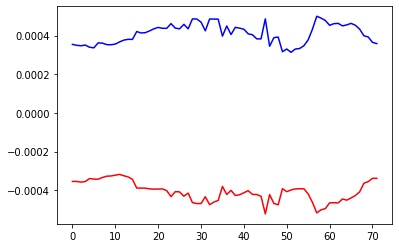

In [157]:
from matplotlib import pyplot as plt

plt.plot([i[1] for i in best_param], color='red')
plt.plot([i[2] for i in best_param], color='blue')

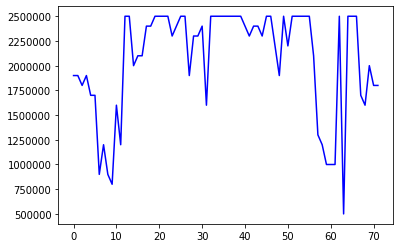

In [158]:
plt.plot([i[3] for i in best_param], color='blue')

# 对手盘买卖全部

In [149]:
file_dic_merge

{0: './Signal_588000_VWAP_duoyinzi/2020-12-14.txt',
 1: './Signal_588000_VWAP_duoyinzi/2020-12-15.txt',
 2: './Signal_588000_VWAP_duoyinzi/2020-12-16.txt',
 3: './Signal_588000_VWAP_duoyinzi/2020-12-17.txt',
 4: './Signal_588000_VWAP_duoyinzi/2020-12-18.txt',
 5: './Signal_588000_VWAP_duoyinzi/2020-12-21.txt',
 6: './Signal_588000_VWAP_duoyinzi/2020-12-22.txt',
 7: './Signal_588000_VWAP_duoyinzi/2020-12-23.txt',
 8: './Signal_588000_VWAP_duoyinzi/2020-12-24.txt',
 9: './Signal_588000_VWAP_duoyinzi/2020-12-25.txt',
 10: './Signal_588000_VWAP_duoyinzi/2020-12-28.txt',
 11: './Signal_588000_VWAP_duoyinzi/2020-12-29.txt',
 12: './Signal_588000_VWAP_duoyinzi/2020-12-30.txt',
 13: './Signal_588000_VWAP_duoyinzi/2020-12-31.txt',
 14: './Signal_588000_VWAP_duoyinzi/2021-01-04.txt',
 15: './Signal_588000_VWAP_duoyinzi/2021-01-05.txt',
 16: './Signal_588000_VWAP_duoyinzi/2021-01-06.txt',
 17: './Signal_588000_VWAP_duoyinzi/2021-01-07.txt',
 18: './Signal_588000_VWAP_duoyinzi/2021-01-08.txt',
 19

# 20 Nov - 21 Apr

In [166]:
ret = []
lst_date = []
lst_num = []
lst_up = []
lst_low = []

for i in range(len(best_param)):
    dt = pd.read_pickle(file_dic_merge[i + day])
    date = file_dic_merge[i + day][30:40]
    thres_up = 0.00045#best_param[i][2]
    thres_low = -0.00045#best_param[i][1]
    signal = dt['PredictY'].to_numpy()
    #print(np.corrcoef(signal, dt['VWAP'].fillna(0)))
    signal[0:5] = 0
    ask = dt['AskPrice1'].to_numpy()
    bid = dt['BidPrice1'].to_numpy()
    ask_v = dt['AskVolume1'].to_numpy()
    bid_v = dt['BidVolume1'].to_numpy()
    abt, volume = threshold(thres_up, thres_low, signal, ask, bid, ask_v, bid_v)
    [position, cash, num_trans, c] = strategy_ret(abt, volume, best_param[i][3])
    if position < 0:
        print(date)
        net_value = (cash + (position) * ask[-1] * 1.0001)
    elif position > 0:
        print(date)
        net_value = (cash + (position) * bid[-1] * 0.9999)
    else:
        net_value = cash
    print(date, net_value)
    lst_num.append(num_trans)
    lst_date.append(date)
    ret.append(net_value)
    lst_up.append(thres_up)
    lst_low.append(thres_low)
    

sum(ret)

2020-12-28 -12762.785290300148
2020-12-29
2020-12-29 -12871.858661600389
2020-12-30
2020-12-30 -11932.447565099195
2020-12-31 12012.228599798982
2021-01-04
2021-01-04 -4204.558723199312
2021-01-05
2021-01-05 6895.341312500648
2021-01-06
2021-01-06 -1943.8343009999953
2021-01-07
2021-01-07 -23753.590754599427
2021-01-08 5897.736694399951
2021-01-11 3364.6962616998353
2021-01-12 20808.591511499748
2021-01-13
2021-01-13 -6628.320840700384
2021-01-14 6466.387378599938
2021-01-15 10375.729150399566
2021-01-18 8823.689443800366
2021-01-19 16292.022140100715
2021-01-20 23746.805568300315
2021-01-21 7066.597482299665
2021-01-22 -869.82909839902
2021-01-25 8622.348027899134
2021-01-26 8073.636579900012
2021-01-27 -14479.120127199218
2021-01-28 -17582.39947580069
2021-01-29 32191.206783700152
2021-02-01 -2228.6325171980716
2021-02-02 -8830.97139689876
2021-02-03 3095.1747009006795
2021-02-04 8479.246893900068
2021-02-05 -1165.587900298502
2021-02-08 4010.9159781008493
2021-02-09 36976.1355114013

558766.9129645183

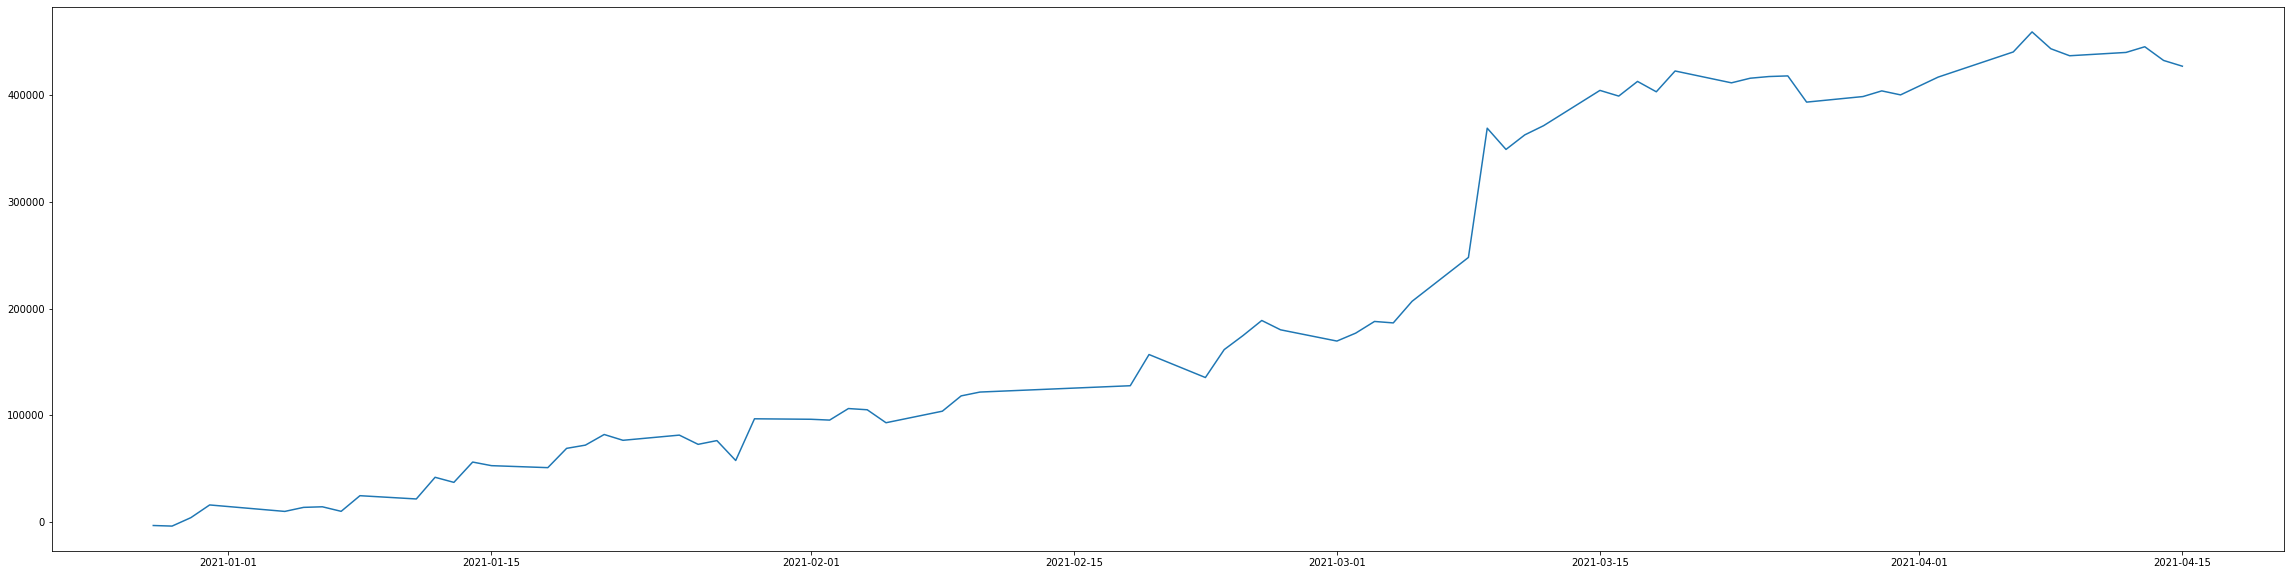

In [160]:
result_588000 = pd.DataFrame({'date': lst_date, 'ret': ret, 'num trans': lst_num})
#result_588000.to_csv('result_588000_feb-mar.csv')

plt.figure(figsize=(40,10))
plt.plot(pd.to_datetime(result_588000['date']),result_588000['ret'].cumsum())

# Compare with KMD Feb - Mar

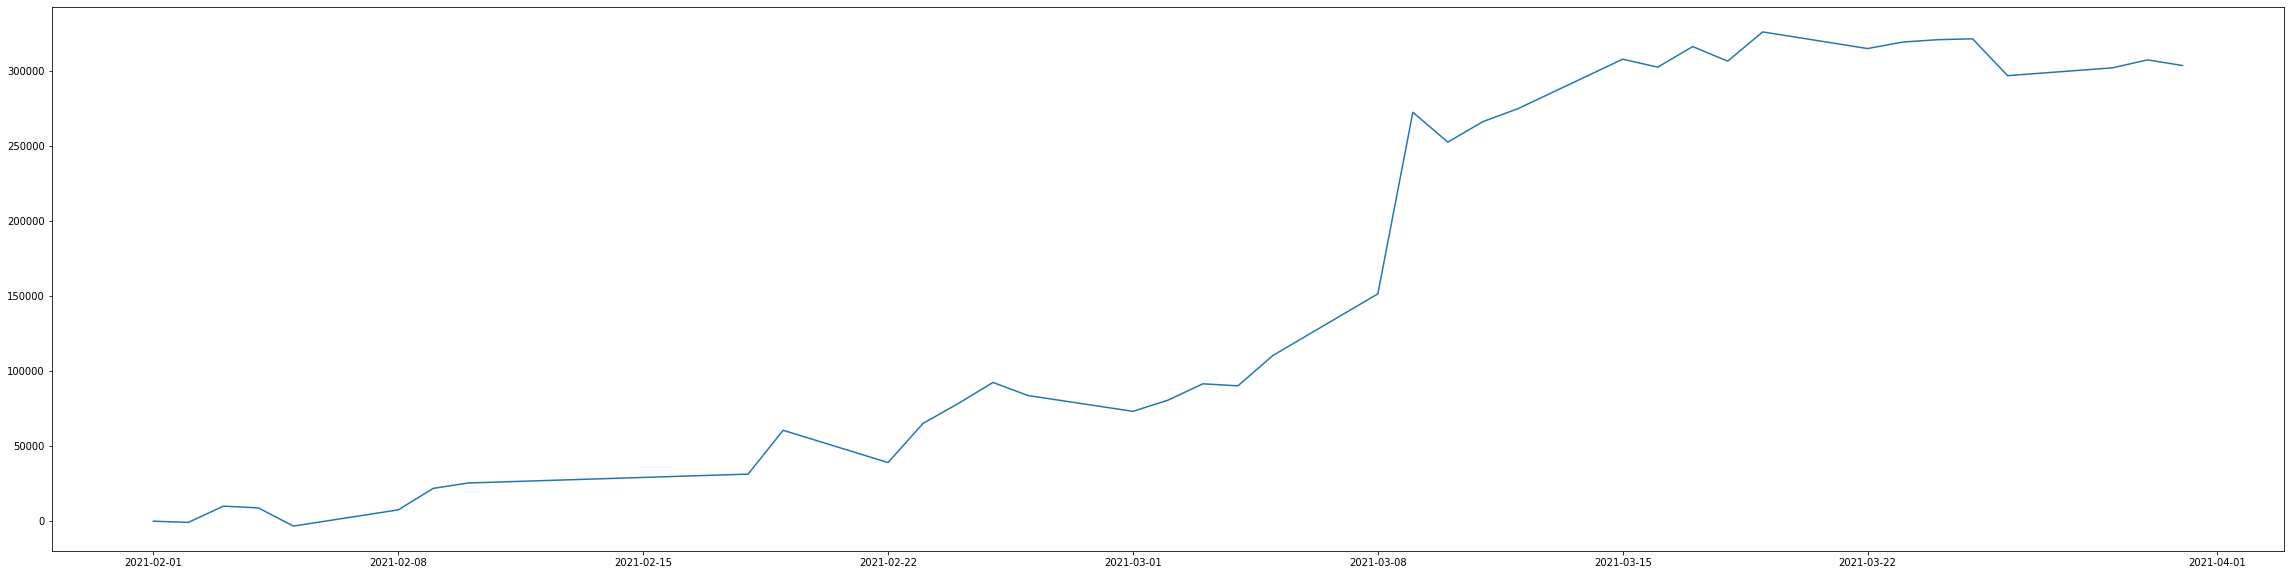

In [165]:
df = pd.Series(ret, index= lst_date)
df.index = pd.to_datetime(df.index)
t = df['2021-02-01':'2021-03-31']

t = t.astype(float)
plt.figure(figsize=(40,10))
plt.plot(t.cumsum())

In [162]:
sum(t)

303679.2583097132

In [163]:
directory = "./kmd2"
i = 0
file_dic_kmd2 = {}
#signal = pd.read_pickle("./Signal_588000_trunc/20201202.txt")
for filename in os.listdir(directory):
    file_dic_kmd2[i] = directory + '/' + filename
    i += 1

In [164]:
directory = "./kmd3"
i = 0
file_dic_kmd3 = {}
#signal = pd.read_pickle("./Signal_588000_trunc/20201202.txt")
for filename in os.listdir(directory):
    file_dic_kmd3[i] = directory + '/' + filename
    i += 1

In [142]:
lst_kmd_earning = []
lst_kmd_date = []
for i in range(len(file_dic_kmd2) - 1):
    df = pd.read_excel(file_dic_kmd2[i])
    lst_kmd_date.append(file_dic_kmd2[i][15:23])
    lst_kmd_earning.append(sum(df[df['证券类别']=='基金']['清算金额']))
    
for i in range(len(file_dic_kmd3) - 1):
    df = pd.read_excel(file_dic_kmd3[i])
    lst_kmd_date.append(file_dic_kmd3[i][15:23])
    lst_kmd_earning.append(sum(df[df['证券类别']=='基金']['清算金额']))

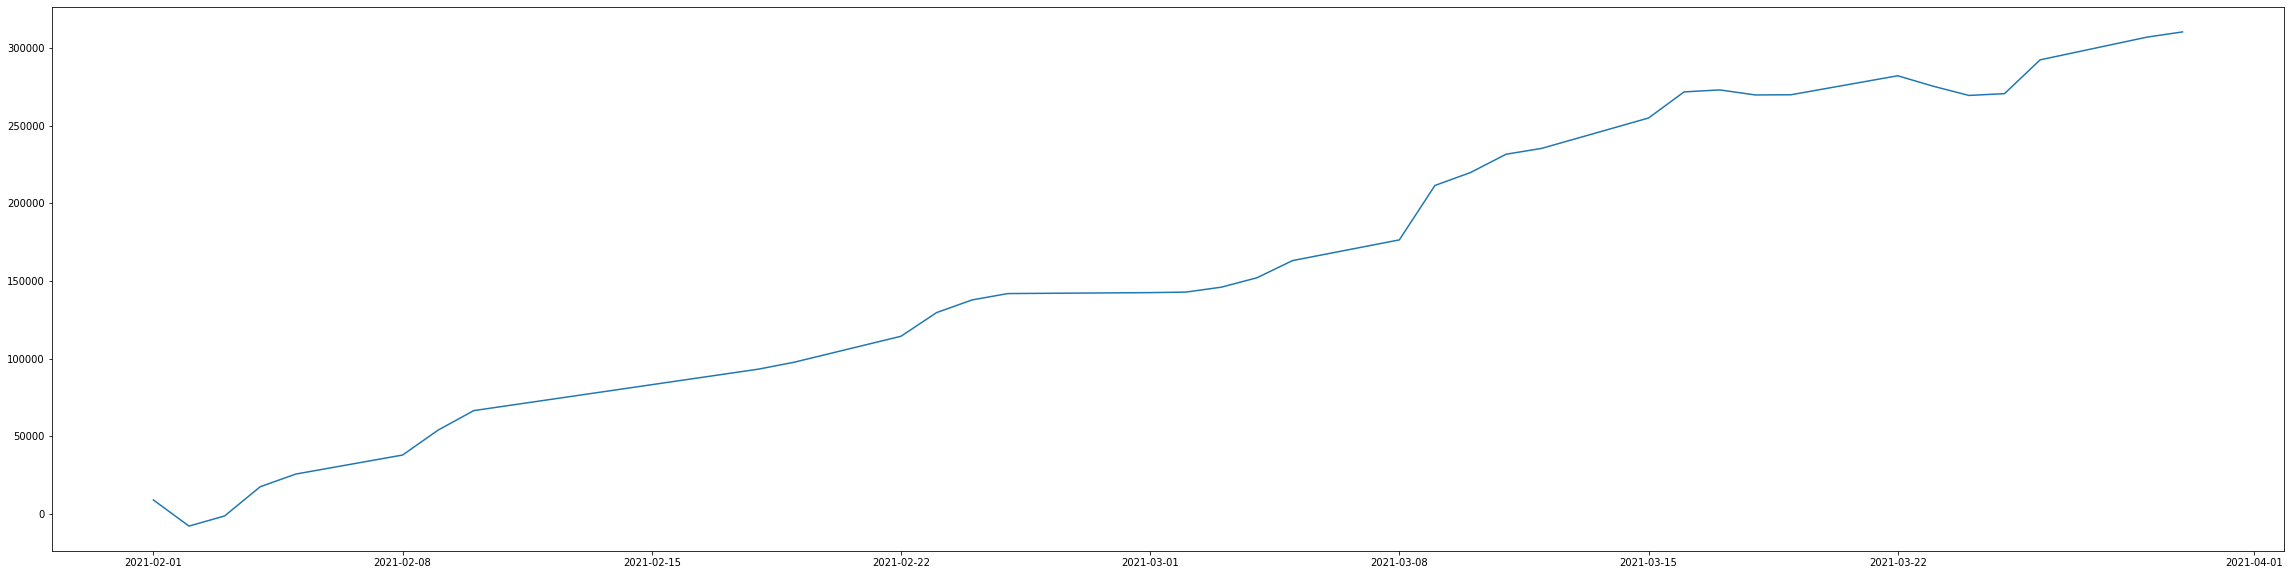

In [143]:
plt.figure(figsize=(40,10))
plt.plot(pd.Series(lst_kmd_earning, index = pd.to_datetime(lst_kmd_date)).cumsum())

# 关注某一天

In [167]:
i = 45

dt = pd.read_pickle(file_dic_merge[i + day])
date = file_dic_merge[i + day][30:40]
thres_up = best_param[i][2]
thres_low = best_param[i][1]
signal = dt['PredictY'].to_numpy()
#print(np.corrcoef(signal, dt['VWAP'].fillna(0)))
signal[0:5] = 0
ask = dt['AskPrice1'].to_numpy()
bid = dt['BidPrice1'].to_numpy()
ask_v = dt['AskVolume1'].to_numpy()
bid_v = dt['BidVolume1'].to_numpy()
abt, volume = threshold(thres_up, thres_low, signal, ask, bid, ask_v, bid_v)
[log, position, cash, num_trans, c] = strategy_ret_log(abt, volume, best_param[i][3], dt.index)
if position < 0:
    print(date)
    net_value = (cash + (position) * ask[-1] * 1.0001)
elif position > 0:
    print(date)
    net_value = (cash + (position) * bid[-1] * 0.9999)
else:
    net_value = cash
print(date, net_value)




2021-03-09
2021-03-09 121165.96022199979


In [169]:
log.to_csv('log.csv')

